In [1]:
'''Train CIFAR10/100 with PyTorch using standard Contrastive Learning. This script tunes evaluates the invariance of
the learned representations.'''
import torch
import torch.backends.cudnn as cudnn

import math
import os
import argparse

from augmentation import ColourDistortion, TensorNormalise, ModuleCompose
from models import *
from configs import get_datasets, get_mean_std
from evaluate import train_reg, test_reg

In [28]:
def predict_alpha(load_from):
    
    num_workers = 2
    reg_lower = -6
    reg_upper = -4
    num_steps = 3

    # Load checkpoint.
    print('==> Loading settings from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    resume_from = os.path.join('./checkpoint', load_from)
    checkpoint = torch.load(resume_from)
    dataset = checkpoint['args']['dataset']
    arch = checkpoint['args']['arch']

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Data
    print('==> Preparing data..')
    _, testset, clftrainset, _, stem, col_distort, batch_transform = get_datasets(
        dataset, augment_clf_train=True, augment_test=True)

    testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                             pin_memory=True)
    clftrainloader = torch.utils.data.DataLoader(clftrainset, batch_size=1000, shuffle=False, num_workers=num_workers,
                                                 pin_memory=True)

    # Model
    print('==> Building model..')
    ##############################################################
    # Encoder
    ##############################################################
    if arch == 'resnet18':
        net = ResNet18(stem=stem)
    elif arch == 'resnet34':
        net = ResNet34(stem=stem)
    elif arch == 'resnet50':
        net = ResNet50(stem=stem)
    else:
        raise ValueError("Bad architecture specification")
    net = net.to(device)

    if device == 'cuda':
        repr_dim = net.representation_dim
        net = torch.nn.DataParallel(net)
        net.representation_dim = repr_dim
        cudnn.benchmark = True

    print('==> Loading encoder from checkpoint..')
    net.load_state_dict(checkpoint['net'])

    batch_transform = batch_transform.to(device)


    def create_dataset(clftrainloader, device, net, target=None):
        if target is None:
            target = device

        net.eval()

        with torch.no_grad():
            store = []
            for batch_idx, (inputs, _) in enumerate(clftrainloader):
                inputs = inputs.to(device)
                rn = col_distort.sample_random_numbers(inputs.shape, inputs.device)
                inputs = batch_transform(inputs, rn)
                representation = net(inputs)
                representation = representation.to(target)
                store.append((representation, rn))

            Xi, y = zip(*store)
            Xi, y = torch.cat(Xi, dim=0), torch.cat(y, dim=0)

        return Xi, y


    best_loss = float('inf')
    X, y = create_dataset(clftrainloader, device, net)
    X_test, y_test = create_dataset(testloader, device, net)
    for reg_weight in torch.exp(math.log(10) * torch.linspace(reg_lower, reg_upper, num_steps,
                                                              dtype=torch.float, device=device)):
        clf = train_reg(X, y, device, reg_weight=reg_weight)
        loss = test_reg(X_test, y_test, clf)
        if loss < best_loss:
            best_loss = loss
    print("Best test loss", best_loss)
    return best_loss

In [7]:
predict_alpha('inv-gp-0_run1_epoch049.pth')

==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03554:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03140: ██████████| 500/500 [00:06<00:00, 75.55it/s]
Loss: 0.03558:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03187

L2 Regularization weight: 0.0001


Loss: 0.03147: ██████████| 500/500 [00:06<00:00, 77.54it/s] 
Loss: 0.03715:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03185

L2 Regularization weight: 0.01


Loss: 0.03406: ██████████| 500/500 [00:02<00:00, 187.29it/s]


Loss: 0.03286
Best test loss 0.0318523570895195


0.0318523570895195

In [8]:
predict_alpha('inv-gp-1_norm_run1_epoch049.pth')

==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03952:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03260: ██████████| 500/500 [01:20<00:00,  6.21it/s]
Loss: 0.03501:           | 1/500 [00:00<00:50,  9.83it/s]       

Loss: 0.03279

L2 Regularization weight: 0.0001


Loss: 0.03301: ██████████| 500/500 [00:35<00:00, 14.21it/s]
Loss: 0.04968:           | 1/500 [00:00<00:50,  9.86it/s]       

Loss: 0.03277

L2 Regularization weight: 0.01


Loss: 0.03788: ██████████| 500/500 [00:11<00:00, 42.05it/s]

Loss: 0.03639
Best test loss 0.03277059271931648


0.03277059271931648

In [10]:
predict_alpha('inv-gp-0_run1_epoch199.pth')

==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03605:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03341: ██████████| 500/500 [00:04<00:00, 115.62it/s]
Loss: 0.03578:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03364

L2 Regularization weight: 0.0001


Loss: 0.03347: ██████████| 500/500 [00:04<00:00, 116.79it/s]
Loss: 0.03775:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03363

L2 Regularization weight: 0.01


Loss: 0.03598: ██████████| 500/500 [00:02<00:00, 217.90it/s]


Loss: 0.03459
Best test loss 0.033630046993494034


0.033630046993494034

In [12]:
predict_alpha('inv-gp-0_run2_epoch199.pth')

==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03569:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03302: ██████████| 500/500 [00:04<00:00, 104.24it/s]
Loss: 0.03597:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03352

L2 Regularization weight: 0.0001


Loss: 0.03308: ██████████| 500/500 [00:04<00:00, 107.47it/s]
Loss: 0.03765:           | 1/500 [00:00<00:51,  9.70it/s]       

Loss: 0.03351

L2 Regularization weight: 0.01


Loss: 0.03553: ██████████| 500/500 [00:02<00:00, 191.10it/s]


Loss: 0.03449
Best test loss 0.03351476415991783


0.03351476415991783

In [11]:
predict_alpha('inv-gp-1_norm_run1_epoch199.pth')

==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03449:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03314: ██████████| 500/500 [00:14<00:00, 35.30it/s]
Loss: 0.04322:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03405

L2 Regularization weight: 0.0001


Loss: 0.03332: ██████████| 500/500 [00:23<00:00, 21.62it/s]
Loss: 0.04093:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03404

L2 Regularization weight: 0.01


Loss: 0.03716: ██████████| 500/500 [00:11<00:00, 42.80it/s]


Loss: 0.03623
Best test loss 0.03403806313872337


0.03403806313872337

In [26]:
base200 = ['inv-gp-0_run1_epoch199.pth','inv-gp-0_run2_epoch199.pth','inv-gp-0_run3_epoch199.pth','inv-gp-0_run4_epoch199.pth','inv-gp-0_run5_epoch199.pth']
base150 = ['inv-gp-0_run1_epoch149.pth','inv-gp-0_run2_epoch149.pth','inv-gp-0_run3_epoch149.pth','inv-gp-0_run4_epoch149.pth','inv-gp-0_run5_epoch149.pth']
base100 = ['inv-gp-0_run1_epoch099.pth','inv-gp-0_run2_epoch099.pth','inv-gp-0_run3_epoch099.pth','inv-gp-0_run4_epoch099.pth','inv-gp-0_run5_epoch099.pth']
base50 =  ['inv-gp-0_run1_epoch049.pth','inv-gp-0_run2_epoch049.pth','inv-gp-0_run3_epoch049.pth','inv-gp-0_run4_epoch049.pth', 'inv-gp-0_run5_epoch049.pth']
base = [base50, base100, base150, base200]
# base = [base50, base100]

In [27]:
gp200 = ['inv-gp-1_norm_run1_epoch199.pth','inv-gp-1_norm_run2_epoch199.pth','inv-gp-1_norm_run3_epoch199.pth', 'inv-gp-1_norm_run4_epoch199.pth','inv-gp-1_norm_run5_epoch199.pth']
gp150 = ['inv-gp-1_norm_run1_epoch149.pth','inv-gp-1_norm_run2_epoch149.pth', 'inv-gp-1_norm_run3_epoch149.pth','inv-gp-1_norm_run4_epoch149.pth','inv-gp-1_norm_run5_epoch149.pth']
gp100 = ['inv-gp-1_norm_run1_epoch099.pth','inv-gp-1_norm_run2_epoch099.pth', 'inv-gp-1_norm_run3_epoch099.pth', 'inv-gp-1_norm_run4_epoch099.pth','inv-gp-1_norm_run5_epoch099.pth']
gp50 = ['inv-gp-1_norm_run1_epoch049.pth','inv-gp-1_norm_run2_epoch049.pth','inv-gp-1_norm_run3_epoch049.pth', 'inv-gp-1_norm_run4_epoch049.pth', 'inv-gp-1_norm_run5_epoch049.pth']
gp = [gp50, gp100, gp150, gp200]

In [29]:
loss_base = []
for base_i in base:
    loss_i = []
    for file in base_i:
        best_loss = predict_alpha(file)
        loss_i.append(best_loss)
    loss_base.append(loss_i)

==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03526:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03133: ██████████| 500/500 [00:06<00:00, 75.21it/s] 
Loss: 0.03540:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03167

L2 Regularization weight: 9.99999e-06


Loss: 0.03134: ██████████| 500/500 [00:06<00:00, 79.71it/s]
Loss: 0.03582:           | 1/500 [00:00<00:51,  9.65it/s]       

Loss: 0.03166

L2 Regularization weight: 0.0001


Loss: 0.03140: ██████████| 500/500 [00:06<00:00, 79.97it/s] 


Loss: 0.03165
Best test loss 0.031654179096221924
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03569:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03194: ██████████| 500/500 [00:06<00:00, 76.56it/s] 
Loss: 0.03591:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03211

L2 Regularization weight: 9.99999e-06


Loss: 0.03194: ██████████| 500/500 [00:06<00:00, 74.23it/s] 
Loss: 0.03692:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03211

L2 Regularization weight: 0.0001


Loss: 0.03201: ██████████| 500/500 [00:06<00:00, 80.43it/s] 


Loss: 0.03209
Best test loss 0.03209270164370537
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03556:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03221: ██████████| 500/500 [00:15<00:00, 32.96it/s]
Loss: 0.03706:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03298

L2 Regularization weight: 9.99999e-06


Loss: 0.03222: ██████████| 500/500 [00:06<00:00, 79.71it/s] 
Loss: 0.03741:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03298

L2 Regularization weight: 0.0001


Loss: 0.03229: ██████████| 500/500 [00:06<00:00, 76.84it/s] 


Loss: 0.03296
Best test loss 0.032958921045064926
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03585:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03224: ██████████| 500/500 [00:06<00:00, 78.85it/s] 
Loss: 0.03612:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03301

L2 Regularization weight: 9.99999e-06


Loss: 0.03225: ██████████| 500/500 [00:06<00:00, 76.58it/s]
Loss: 0.03594:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03301

L2 Regularization weight: 0.0001


Loss: 0.03231: ██████████| 500/500 [00:06<00:00, 81.56it/s] 


Loss: 0.03300
Best test loss 0.03299608454108238
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03688:           | 1/500 [00:00<01:05,  7.61it/s]       


L2 Regularization weight: 1e-06


Loss: 0.03162: ██████████| 500/500 [00:06<00:00, 71.66it/s] 
Loss: 0.03687:           | 1/500 [00:00<00:51,  9.62it/s]       

Loss: 0.03249

L2 Regularization weight: 9.99999e-06


Loss: 0.03163: ██████████| 500/500 [00:07<00:00, 70.10it/s] 
Loss: 0.03633:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03249

L2 Regularization weight: 0.0001


Loss: 0.03170: ██████████| 500/500 [00:07<00:00, 65.62it/s] 


Loss: 0.03248
Best test loss 0.032479383051395416
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03758:           | 1/500 [00:00<00:52,  9.57it/s]       


L2 Regularization weight: 1e-06


Loss: 0.03359: ██████████| 500/500 [00:05<00:00, 95.61it/s] 
Loss: 0.03882:           | 1/500 [00:00<00:57,  8.75it/s]       

Loss: 0.03428

L2 Regularization weight: 9.99999e-06


Loss: 0.03359: ██████████| 500/500 [00:06<00:00, 80.39it/s] 
Loss: 0.03769:           | 1/500 [00:00<00:57,  8.69it/s]       

Loss: 0.03428

L2 Regularization weight: 0.0001


Loss: 0.03365: ██████████| 500/500 [00:05<00:00, 84.50it/s] 


Loss: 0.03427
Best test loss 0.034272175282239914
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03640:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03325: ██████████| 500/500 [00:05<00:00, 93.43it/s] 
Loss: 0.03741:           | 1/500 [00:00<00:51,  9.61it/s]       

Loss: 0.03362

L2 Regularization weight: 9.99999e-06


Loss: 0.03326: ██████████| 500/500 [00:05<00:00, 91.36it/s] 
Loss: 0.03608:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03361

L2 Regularization weight: 0.0001


Loss: 0.03331: ██████████| 500/500 [00:05<00:00, 99.48it/s] 


Loss: 0.03361
Best test loss 0.03360540419816971
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03556:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03276: ██████████| 500/500 [00:06<00:00, 82.27it/s] 
Loss: 0.03674:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03332

L2 Regularization weight: 9.99999e-06


Loss: 0.03276: ██████████| 500/500 [00:06<00:00, 81.48it/s] 
Loss: 0.03584:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03332

L2 Regularization weight: 0.0001


Loss: 0.03281: ██████████| 500/500 [00:05<00:00, 89.28it/s] 


Loss: 0.03331
Best test loss 0.03331141173839569
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03683:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03294: ██████████| 500/500 [00:05<00:00, 96.30it/s] 
Loss: 0.03666:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03341

L2 Regularization weight: 9.99999e-06


Loss: 0.03294: ██████████| 500/500 [00:05<00:00, 92.09it/s] 
Loss: 0.03609:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03340

L2 Regularization weight: 0.0001


Loss: 0.03299: ██████████| 500/500 [00:05<00:00, 94.68it/s] 


Loss: 0.03340
Best test loss 0.03339635580778122
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03634:           | 1/500 [00:00<00:51,  9.74it/s]       


L2 Regularization weight: 1e-06


Loss: 0.03290: ██████████| 500/500 [00:05<00:00, 94.00it/s] 
Loss: 0.03616:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03362

L2 Regularization weight: 9.99999e-06


Loss: 0.03290: ██████████| 500/500 [00:05<00:00, 95.12it/s] 
Loss: 0.03602:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03362

L2 Regularization weight: 0.0001


Loss: 0.03295: ██████████| 500/500 [00:05<00:00, 94.88it/s] 


Loss: 0.03361
Best test loss 0.03361125662922859
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03657:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03346: ██████████| 500/500 [00:04<00:00, 110.56it/s]
Loss: 0.03656:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03411

L2 Regularization weight: 9.99999e-06


Loss: 0.03346: ██████████| 500/500 [00:04<00:00, 101.71it/s]
Loss: 0.03654:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03411

L2 Regularization weight: 0.0001


Loss: 0.03351: ██████████| 500/500 [00:13<00:00, 36.19it/s]


Loss: 0.03411
Best test loss 0.03410811349749565
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03593:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03344: ██████████| 500/500 [00:04<00:00, 113.57it/s]
Loss: 0.03589:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03427

L2 Regularization weight: 9.99999e-06


Loss: 0.03345: ██████████| 500/500 [00:04<00:00, 116.84it/s]
Loss: 0.03638:           | 1/500 [00:00<00:51,  9.73it/s]       

Loss: 0.03427

L2 Regularization weight: 0.0001


Loss: 0.03349: ██████████| 500/500 [00:04<00:00, 115.57it/s]


Loss: 0.03426
Best test loss 0.034258391708135605
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03670:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03400: ██████████| 500/500 [00:05<00:00, 91.10it/s] 
Loss: 0.03652:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03464

L2 Regularization weight: 9.99999e-06


Loss: 0.03401: ██████████| 500/500 [00:05<00:00, 97.32it/s] 
Loss: 0.03704:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03464

L2 Regularization weight: 0.0001


Loss: 0.03406: ██████████| 500/500 [00:05<00:00, 94.89it/s] 


Loss: 0.03463
Best test loss 0.03462822362780571
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03614:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03347: ██████████| 500/500 [00:05<00:00, 92.25it/s] 
Loss: 0.03607:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03393

L2 Regularization weight: 9.99999e-06


Loss: 0.03348: ██████████| 500/500 [00:05<00:00, 92.27it/s] 
Loss: 0.03750:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03393

L2 Regularization weight: 0.0001


Loss: 0.03353: ██████████| 500/500 [00:05<00:00, 95.36it/s] 


Loss: 0.03393
Best test loss 0.03392939642071724
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03658:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03321: ██████████| 500/500 [00:05<00:00, 98.99it/s] 
Loss: 0.03622:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03405

L2 Regularization weight: 9.99999e-06


Loss: 0.03322: ██████████| 500/500 [00:04<00:00, 103.43it/s]
Loss: 0.03638:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03404

L2 Regularization weight: 0.0001


Loss: 0.03326: ██████████| 500/500 [00:13<00:00, 36.41it/s]


Loss: 0.03404
Best test loss 0.034036848694086075
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03571:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03344: ██████████| 500/500 [00:04<00:00, 122.14it/s]
Loss: 0.03596:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03382

L2 Regularization weight: 9.99999e-06


Loss: 0.03344: ██████████| 500/500 [00:04<00:00, 114.99it/s]
Loss: 0.03636:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03381

L2 Regularization weight: 0.0001


Loss: 0.03349: ██████████| 500/500 [00:04<00:00, 115.60it/s]


Loss: 0.03381
Best test loss 0.03380674123764038
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03569:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03310: ██████████| 500/500 [00:04<00:00, 114.57it/s]
Loss: 0.03544:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03418

L2 Regularization weight: 9.99999e-06


Loss: 0.03311: ██████████| 500/500 [00:04<00:00, 120.29it/s]
Loss: 0.03534:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03418

L2 Regularization weight: 0.0001


Loss: 0.03316: ██████████| 500/500 [00:04<00:00, 113.61it/s]


Loss: 0.03417
Best test loss 0.03417329490184784
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03611:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03402: ██████████| 500/500 [00:04<00:00, 111.03it/s]
Loss: 0.03699:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03498

L2 Regularization weight: 9.99999e-06


Loss: 0.03402: ██████████| 500/500 [00:04<00:00, 108.59it/s]
Loss: 0.03680:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03498

L2 Regularization weight: 0.0001


Loss: 0.03407: ██████████| 500/500 [00:04<00:00, 118.03it/s]


Loss: 0.03497
Best test loss 0.03496694937348366
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03642:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03410: ██████████| 500/500 [00:04<00:00, 117.45it/s]
Loss: 0.03717:           | 1/500 [00:00<00:50,  9.80it/s]       

Loss: 0.03426

L2 Regularization weight: 9.99999e-06


Loss: 0.03410: ██████████| 500/500 [00:04<00:00, 118.99it/s]
Loss: 0.03657:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03426

L2 Regularization weight: 0.0001


Loss: 0.03415: ██████████| 500/500 [00:04<00:00, 115.76it/s]


Loss: 0.03426
Best test loss 0.034256190061569214
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03550:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03282: ██████████| 500/500 [00:13<00:00, 37.72it/s]
Loss: 0.03546:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03355

L2 Regularization weight: 9.99999e-06


Loss: 0.03282: ██████████| 500/500 [00:04<00:00, 112.78it/s]
Loss: 0.03526:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03355

L2 Regularization weight: 0.0001


Loss: 0.03288: ██████████| 500/500 [00:04<00:00, 112.71it/s]


Loss: 0.03355
Best test loss 0.03354700282216072


In [30]:
import numpy as np
base_mean = torch.tensor(loss_base).mean(axis = 1)
base_std = torch.tensor(loss_base).std(axis = 1)/np.sqrt(5)

In [31]:
print(base_mean)
print(base_std)

tensor([0.0324, 0.0336, 0.0342, 0.0342])
tensor([0.0003, 0.0002, 0.0001, 0.0002])


In [32]:
loss_gp = []
for base_i in gp:
    loss_i = []
    for file in base_i:
        best_loss = predict_alpha(file)
        loss_i.append(best_loss)
    loss_gp.append(loss_i)

==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04153:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03241: ██████████| 500/500 [01:16<00:00,  6.51it/s]
Loss: 0.04054:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03279

L2 Regularization weight: 9.99999e-06


Loss: 0.03245: ██████████| 500/500 [01:19<00:00,  6.32it/s]
Loss: 0.04157:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03278

L2 Regularization weight: 0.0001


Loss: 0.03281: ██████████| 500/500 [01:03<00:00,  7.83it/s]


Loss: 0.03280
Best test loss 0.032782550901174545
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04169:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03160: ██████████| 500/500 [01:25<00:00,  5.86it/s]
Loss: 0.03698:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03220

L2 Regularization weight: 9.99999e-06


Loss: 0.03164: ██████████| 500/500 [01:20<00:00,  6.24it/s]
Loss: 0.03905:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03219

L2 Regularization weight: 0.0001


Loss: 0.03196: ██████████| 500/500 [01:05<00:00,  7.67it/s]


Loss: 0.03219
Best test loss 0.032192353159189224
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04125:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03176: ██████████| 500/500 [00:44<00:00, 11.17it/s]
Loss: 0.04116:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03244

L2 Regularization weight: 9.99999e-06


Loss: 0.03181: ██████████| 500/500 [00:38<00:00, 13.12it/s]
Loss: 0.03975:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03243

L2 Regularization weight: 0.0001


Loss: 0.03215: ██████████| 500/500 [00:31<00:00, 15.78it/s]


Loss: 0.03245
Best test loss 0.03243108093738556
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03848:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03273: ██████████| 500/500 [01:19<00:00,  6.29it/s]
Loss: 0.04051:           | 1/500 [00:00<00:52,  9.56it/s]       

Loss: 0.03309

L2 Regularization weight: 9.99999e-06


Loss: 0.03278: ██████████| 500/500 [01:20<00:00,  6.21it/s]
Loss: 0.04040:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03308

L2 Regularization weight: 0.0001


Loss: 0.03325: ██████████| 500/500 [00:34<00:00, 14.63it/s]


Loss: 0.03312
Best test loss 0.0330786369740963
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04094:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03278: ██████████| 500/500 [00:35<00:00, 14.21it/s]
Loss: 0.04087:           | 1/500 [00:00<00:51,  9.66it/s]       

Loss: 0.03304

L2 Regularization weight: 9.99999e-06


Loss: 0.03282: ██████████| 500/500 [00:33<00:00, 14.81it/s]
Loss: 0.04077:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03304

L2 Regularization weight: 0.0001


Loss: 0.03315: ██████████| 500/500 [00:29<00:00, 16.84it/s]


Loss: 0.03302
Best test loss 0.03302151337265968
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04274:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03319: ██████████| 500/500 [01:30<00:00,  5.51it/s]
Loss: 0.04243:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03371

L2 Regularization weight: 9.99999e-06


Loss: 0.03323: ██████████| 500/500 [01:34<00:00,  5.28it/s]
Loss: 0.04295:           | 1/500 [00:00<00:51,  9.76it/s]       

Loss: 0.03370

L2 Regularization weight: 0.0001


Loss: 0.03348: ██████████| 500/500 [01:30<00:00,  5.50it/s]


Loss: 0.03369
Best test loss 0.03369256108999252
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04270:           | 1/500 [00:00<00:52,  9.51it/s]       


L2 Regularization weight: 1e-06


Loss: 0.03187: ██████████| 500/500 [01:24<00:00,  5.91it/s]
Loss: 0.04242:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03271

L2 Regularization weight: 9.99999e-06


Loss: 0.03191: ██████████| 500/500 [01:28<00:00,  5.65it/s]
Loss: 0.04217:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03270

L2 Regularization weight: 0.0001


Loss: 0.03219: ██████████| 500/500 [01:15<00:00,  6.66it/s]


Loss: 0.03272
Best test loss 0.03270367905497551
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04134:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03249: ██████████| 500/500 [01:08<00:00,  7.28it/s]
Loss: 0.04429:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03340

L2 Regularization weight: 9.99999e-06


Loss: 0.03252: ██████████| 500/500 [01:15<00:00,  6.65it/s]
Loss: 0.04138:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03340

L2 Regularization weight: 0.0001


Loss: 0.03278: ██████████| 500/500 [01:01<00:00,  8.11it/s]


Loss: 0.03338
Best test loss 0.03338354453444481
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.03456:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03287: ██████████| 500/500 [00:16<00:00, 31.05it/s]
Loss: 0.03446:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03397

L2 Regularization weight: 9.99999e-06


Loss: 0.03290: ██████████| 500/500 [00:27<00:00, 18.09it/s]
Loss: 0.04119:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03397

L2 Regularization weight: 0.0001


Loss: 0.03294: ██████████| 500/500 [01:20<00:00,  6.18it/s]


Loss: 0.03371
Best test loss 0.03370827063918114
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04227:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03217: ██████████| 500/500 [01:41<00:00,  4.94it/s]
Loss: 0.04505:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03274

L2 Regularization weight: 9.99999e-06


Loss: 0.03220: ██████████| 500/500 [01:37<00:00,  5.14it/s]
Loss: 0.04097:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03274

L2 Regularization weight: 0.0001


Loss: 0.03245: ██████████| 500/500 [01:15<00:00,  6.58it/s]


Loss: 0.03274
Best test loss 0.03273548185825348
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04202:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03390: ██████████| 500/500 [00:29<00:00, 17.04it/s]
Loss: 0.04527:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03430

L2 Regularization weight: 9.99999e-06


Loss: 0.03392: ██████████| 500/500 [00:37<00:00, 13.40it/s]
Loss: 0.04315:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03429

L2 Regularization weight: 0.0001


Loss: 0.03410: ██████████| 500/500 [00:32<00:00, 15.26it/s]


Loss: 0.03429
Best test loss 0.03428712859749794
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04545:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03255: ██████████| 500/500 [01:35<00:00,  5.24it/s]
Loss: 0.04183:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03344

L2 Regularization weight: 9.99999e-06


Loss: 0.03258: ██████████| 500/500 [01:31<00:00,  5.44it/s]
Loss: 0.04151:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03344

L2 Regularization weight: 0.0001


Loss: 0.03279: ██████████| 500/500 [01:15<00:00,  6.64it/s]


Loss: 0.03344
Best test loss 0.033438540995121
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04328:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03214: ██████████| 500/500 [01:16<00:00,  6.53it/s]
Loss: 0.03453:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03246

L2 Regularization weight: 9.99999e-06


Loss: 0.03250: ██████████| 500/500 [00:15<00:00, 32.89it/s]
Loss: 0.04109:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03284

L2 Regularization weight: 0.0001


Loss: 0.03240: ██████████| 500/500 [01:09<00:00,  7.20it/s]


Loss: 0.03247
Best test loss 0.03246288001537323
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04237:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03189: ██████████| 500/500 [01:46<00:00,  4.69it/s]
Loss: 0.25795:           | 1/500 [00:00<00:54,  9.23it/s]       

Loss: 0.03235

L2 Regularization weight: 9.99999e-06


Loss: 0.03192: ██████████| 500/500 [01:43<00:00,  4.81it/s]
Loss: 0.04120:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03235

L2 Regularization weight: 0.0001


Loss: 0.03213: ██████████| 500/500 [01:26<00:00,  5.77it/s]


Loss: 0.03234
Best test loss 0.03234489634633064
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04309:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03249: ██████████| 500/500 [01:29<00:00,  5.60it/s]
Loss: 0.04526:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03356

L2 Regularization weight: 9.99999e-06


Loss: 0.03251: ██████████| 500/500 [01:26<00:00,  5.77it/s]
Loss: 0.03530:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03356

L2 Regularization weight: 0.0001


Loss: 0.03269: ██████████| 500/500 [01:07<00:00,  7.42it/s]


Loss: 0.03355
Best test loss 0.03355387598276138
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04531:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03317: ██████████| 500/500 [00:34<00:00, 14.40it/s]
Loss: 0.04279:           | 1/500 [00:00<00:50,  9.91it/s]       

Loss: 0.03389

L2 Regularization weight: 9.99999e-06


Loss: 0.03318: ██████████| 500/500 [00:30<00:00, 16.61it/s]
Loss: 0.03566:           | 1/500 [00:00<00:52,  9.55it/s]       

Loss: 0.03389

L2 Regularization weight: 0.0001


Loss: 0.03333: ██████████| 500/500 [00:13<00:00, 37.70it/s]


Loss: 0.03389
Best test loss 0.03388511762022972
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04375:           | 1/500 [00:00<00:53,  9.36it/s]       


L2 Regularization weight: 1e-06


Loss: 0.03226: ██████████| 500/500 [01:28<00:00,  5.64it/s]
Loss: 0.04302:           | 1/500 [00:00<00:51,  9.74it/s]       

Loss: 0.03300

L2 Regularization weight: 9.99999e-06


Loss: 0.03229: ██████████| 500/500 [01:35<00:00,  5.25it/s]
Loss: 0.03560:           | 1/500 [00:00<00:50,  9.82it/s]       

Loss: 0.03300

L2 Regularization weight: 0.0001


Loss: 0.03253: ██████████| 500/500 [01:04<00:00,  7.71it/s]


Loss: 0.03300
Best test loss 0.03299534320831299
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04285:           | 1/500 [00:00<00:51,  9.65it/s]       


L2 Regularization weight: 1e-06


Loss: 0.03282: ██████████| 500/500 [01:21<00:00,  6.14it/s]
Loss: 0.04310:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03323

L2 Regularization weight: 9.99999e-06


Loss: 0.03284: ██████████| 500/500 [01:06<00:00,  7.49it/s]
Loss: 0.04414:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03323

L2 Regularization weight: 0.0001


Loss: 0.03304: ██████████| 500/500 [01:11<00:00,  7.00it/s]


Loss: 0.03323
Best test loss 0.033226173371076584
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04366:           | 1/500 [00:00<00:52,  9.45it/s]       


L2 Regularization weight: 1e-06


Loss: 0.03308: ██████████| 500/500 [01:32<00:00,  5.38it/s]
Loss: 0.03563:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03421

L2 Regularization weight: 9.99999e-06


Loss: 0.03311: ██████████| 500/500 [01:14<00:00,  6.74it/s]
Loss: 0.04394:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03421

L2 Regularization weight: 0.0001


Loss: 0.03330: ██████████| 500/500 [01:32<00:00,  5.43it/s]


Loss: 0.03420
Best test loss 0.03419564291834831
==> Loading settings from checkpoint..
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
==> Building model..
==> Loading encoder from checkpoint..


Loss: 0.04308:           | 0/500 [00:00<?, ?it/s]               


L2 Regularization weight: 1e-06


Loss: 0.03310: ██████████| 500/500 [01:15<00:00,  6.62it/s]
Loss: 0.04623:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03362

L2 Regularization weight: 9.99999e-06


Loss: 0.03312: ██████████| 500/500 [01:16<00:00,  6.54it/s]
Loss: 0.04406:           | 0/500 [00:00<?, ?it/s]               

Loss: 0.03362

L2 Regularization weight: 0.0001


Loss: 0.03331: ██████████| 500/500 [01:07<00:00,  7.38it/s]


Loss: 0.03362
Best test loss 0.03361799195408821


In [33]:
gp_mean = torch.tensor(loss_gp).mean(axis = 1)
gp_std = torch.tensor(loss_gp).std(axis = 1)/np.sqrt(5)

In [34]:
print(gp_mean)
print(gp_std)

tensor([0.0327, 0.0332, 0.0332, 0.0336])
tensor([0.0002, 0.0002, 0.0004, 0.0002])


In [35]:
import matplotlib.pyplot as plt

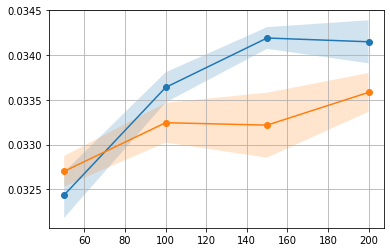

In [36]:
epoch = [i*50 for i in range(1,5)]
plt.plot(epoch, base_mean, marker = 'o', label = 'baseline')
plt.fill_between(epoch, base_mean - 1*base_std, base_mean + 1*base_std, alpha = 0.2)
plt.plot(epoch, gp_mean, marker = 'o', label = 'gradient penalty')
plt.fill_between(epoch, gp_mean - 1*gp_std, gp_mean + 1*gp_std, alpha = 0.2)
plt.grid(True)